# **ABOUT DATASET**

iFood is the lead food delivery app in Brazil, present in over a thousand cities. Keeping a high customer engagement is key for growing and consolidating the company’s position as the market leader. Data Analysts working within the data team are constantly challenged to provide insights and value to the company through open scope projects. This case intends to simulate that. In this case, you are presented a sample dataset, that mocks metainformation on the customer and on iFood campaign interactions with that customer. It is your challenge to understand the data, find business opportunities & insights and to propose any data driven action to optimize the campaigns results & generate value to the company. This case aims to evaluate your Data skills and knowledge for two possible roles:

1. Data Analyst Business:

    - Perform robust exploratory analysis, rich with business insights & data driven proposals to add value to the company and have strong communication skills to influence the decision making.
    
2. Data Advanced Analytics:

    - Perform robust exploratory analysis, using advanced analytics tools and statistical methods to generate data products to optimize business results (predictive & clusterization models, for example).

## The Company

Consider a well-established company operating in the retail food sector. Presently they have around several hundred thousands of registered customers and serve almost one million consumers a year. They sell products from 5 major categories: wines, rare meat products, exotic fruits, specially prepared fish and sweet products. These can further be divided into gold and regular products. The customers can order and acquire products through 3 sales channels: physical stores, catalogs and company’s website. Globally, the company had solid revenues and a healthy bottom line in the past 3 years, but the profit growth perspectives for the next 3 years are not promising... For this reason, several strategic initiatives are being considered to invert this situation. One is to improve the performance of marketing activities, with a special focus on marketing campaigns.

## The Objective

The objective of the team is to build a predictive model that will produce the highest profit for the next direct marketing campaign, scheduled for the next month. The new campaign, sixth, aims at selling a new gadget to the Customer Database. To build the model, a pilot campaign involving
2.240 customers was carried out. The customers were selected at random and contacted by phone regarding the acquisition of the gadget. During the following months, customers who bought the offer were properly labeled. The total cost of the sample campaign was 6.720MU and the revenue generated by the customers who accepted the offer was 3.674MU. Globally the campaign had a profit of -3.046MU. The success rate of the campaign was 15%. The objective is of the team is to develop a model that predicts customer behavior and to apply it to the rest of the customer base. Hopefully the model will allow the company to cherry pick the customers that are most likely to purchase the offer while leaving out the non-respondents, making the next campaign highly profitable. Moreover, other than maximizing the profit of the campaign, the CMO is interested in understanding to study the characteristic features of those customers who are willing to buy the gadget.


In a nutshell, the key objectives are:

1. Explore the data – don’t just plot means and counts. Provide insights, define cause and effect. Provide a better understanding of the characteristic features of respondents;

2. Propose and describe a customer segmentation based on customers behaviors;

3. Create a predictive model which allows the company to maximize the profit of the next marketing campaign.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# **EXPLORING THE DATA**

A look at the dataset indicates a total of 2240 customers with 29 features collected for the categorization of iFood's customers.

In [2]:
date_cols = ['Year_Birth', 'Dt_Customer']
ifood = pd.read_csv('marketing_campaign.csv',
                    delimiter=';',
                    parse_dates=date_cols)

print('customers: ', ifood['ID'].nunique())

print('features: ', ifood.shape[1], '\n')

displ_cols = ['ID', 'Education', 'Income', 'Recency', 'Response']
ifood[displ_cols].head()

customers:  2240
features:  29 



,ID,Education,Income,Recency,Response
0,5524,Graduation,58138.0,58,1
1,2174,Graduation,46344.0,38,0
2,4141,Graduation,71613.0,26,0
3,6182,Graduation,26646.0,26,0
4,5324,PhD,58293.0,94,0


## Handling Missing Data

Previously, it was confirmed that there are no duplicate entries. However, there are 24 missing entries for the yearly household `'Income'` feature.

In [3]:
mis_ftrs = ifood.isna().sum()>1
print(ifood.isna().sum()[mis_ftrs])

Income    24
dtype: int64


Being that median is less bias than the average, it will be used for filling in the missing values. The criteria being that the median income is based on the education level. Nonetheless, the decision to use median to fill missing values does not imply that it will be the statistics that will be used henceforth. 

In [4]:
ifood['Income'] = (ifood['Income']
                   .fillna(ifood.groupby(['Education'])
                           ['Income']
                           .transform('median')))
print()
print('missing income entries: ', ifood['Income'].isna().sum())


missing income entries:  0


## Superfluous Features

The `'Z_CostContact'` and `'Z_Revenue'` features have only one value for all the customers. Therefore, they are unnecessary for further analysis.

In [5]:
redun_ftrs = ifood.nunique()[ifood.nunique() < 2]
ifood = ifood.drop(list(redun_ftrs.keys()), axis=1)
redun_ftrs

Z_CostContact    1
Z_Revenue        1
dtype: int64

The `'Year_Birth'` feature is useful when calculating the ages of the customers. However, the feature becomes redundant once the calculation is done so it is removed from the data. Before calculating the age of each customer, it is important that we look at the time line for the study. A look at the data shows that the data was collected between 2012-07-30 to 2014-06-29. This means that any calculation involving dates will be based on this time line.

In [6]:
ifood['Dt_Customer'].agg(['min', 'max'])

min   2012-07-30
max   2014-06-29
Name: Dt_Customer, dtype: datetime64[ns]

With this information, the `'Age'` feature is created while the `'Year_Birth'` feature is removed. As we can see that the average age of these customers is 45 years with the youngest customer being 18 years while the oldest is 121.

In [7]:
now = ifood['Dt_Customer'].max().year

ifood['Age'] = now - ifood['Year_Birth'].dt.year 
ifood = ifood.drop('Year_Birth', axis=1)
ifood['Age'].agg(['mean', 'min', 'max']).round(0)

mean     45.0
min      18.0
max     121.0
Name: Age, dtype: float64

A closer look reveals that there are only three customers who are over 75 years; in fact, they are over 100 years. Despite the old age, my assumption is that these customers are being assisted by their loved ones when it comes to purchases iFood products.

In [8]:
ifood[['ID','Age']][ifood['Age']>73]

,ID,Age
192,7829,114
239,11004,121
339,1150,115
1950,6663,74


After these feature engineering, let's dive into exploratory data analysis. Note that more features will be created as need arise. In the next section, the goal will be to perform customer segmentation based on demographics, behavioral analytics and machine learning. Keep in mind that the success rate of the campaign was 15%.

# **DEMOGRAPHIC CUSTOMER SEGMENTATION**

One way organizations use to divide the market into distinct subgroups is by the use of demographic data. These data include factors like age, gender, education, income, e.t.c and they aid businesses in comprehending their clientele so that their requirements can be better met. In the next few sections, we'll have a look at success rate based on these demographics. Before diving deep, a `conversion_rate()` function is defined which will calculate the conversion/success rates based on the provided demographics.

In [9]:
def conversion_rate(variable, df):
    """Function to calculate the conversion rate"""
    conv_users = df.groupby(variable)['Response'].sum()
    total_users = df[variable].value_counts()
    conversion_rate = round((conv_users/total_users)*100,0)
    return conversion_rate

Another function that will be useful is the `explain_plot()`. This function is used to plot a scatterplot that provides more insight on the feature that is being examined given that another factor is considered.

In [10]:
def explain_plot(df, x, y):
    sns.scatterplot(x=x, 
                    y=y, 
                    hue=df.index, 
                    s=80, 
                    data=df)
    plt.axvline(x=15, color='#f67e6d', linestyle='--', 
                label="Overall Campaign's Success Rate")

## Education Level

How did education contribute to the success rate? Well, customers with PhD had a high success rate (21% against the overall 15%) while those with basic education had the poorest conversion rate (4% against the overall 15%). What could be the reason? Additionally, customers with Master (15%) and/or PhD (21%) were the ones who attained or were above the campaign success rate of 15%. The rest were below the success rate: Basic (4%), 2n Cycle (11%), and Graduation (13%).

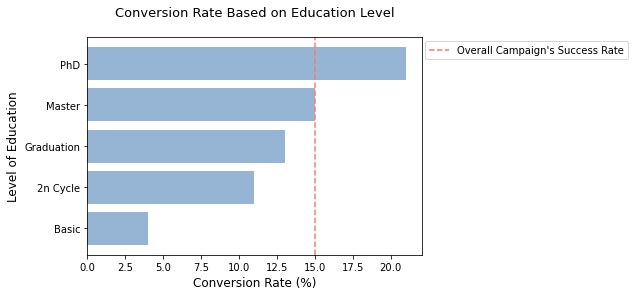

In [11]:
edu_conv_rate = (conversion_rate('Education', df=ifood)
                 .sort_values())

plt.barh(edu_conv_rate.index, 
        edu_conv_rate, 
        color='#2f6aa8', 
        alpha=0.5)
plt.axvline(x=15, color='#f67e6d', linestyle='--',
            label="Overall Campaign's Success Rate")

plt.legend(loc=(1.01, 0.9))
plt.ylabel('Level of Education', size=12)
plt.xlabel('Conversion Rate (%)', size=12)
plt.title('Conversion Rate Based on Education Level\n', size=13);

### The Number Effect

One of the reason that comes to mind is the frequency of customers in the `'Education'` feature. Maybe those with PhD are a few and this could mean high or low conversion rate. A quick check shows that an assumption can be made that customers with Basic and 2n Cycle education could have low conversion rate due to their low frequency in the data; 54 and 203 respectively. However, similar conclusions cannot be made when it comes to the other education groups. Those categorized as graduated consist of 1127 participants while those with masters and PhD consist of 370 and 486 participants respectively.

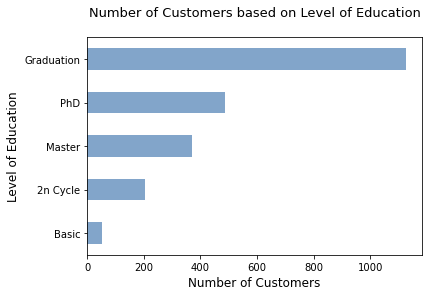

In [12]:
(ifood['Education']
 .value_counts(ascending=True)
 .plot(kind='barh', 
       color='#2f6aa8', 
       alpha=0.6))

plt.ylabel('Level of Education', size=12)
plt.xlabel('Number of Customers', size=12)
plt.title('Number of Customers based on Level of Education\n', 
          size=13);

### The Income Effect

Another reason could be to examine the average household income based on these education groups. As compared to the previous results, household `'Income'` shows a positive relationship; that is, as the level of education goes up, income also goes up and this explains the cause of the increase in conversion rate. This trend may imply that after accounting for customer's income when grouping customer's based on their education status, higher level of education could mean more income which then could translate to more success rate of iFood products. 

**Heads up:** To interpret this plot and similar subsequent plots, the dotted orange line is the cut-off point of the campaign's success rate. Therefore, the values to the left fall below the campaign's success rate while those to the right fall above the campaign's success rate.

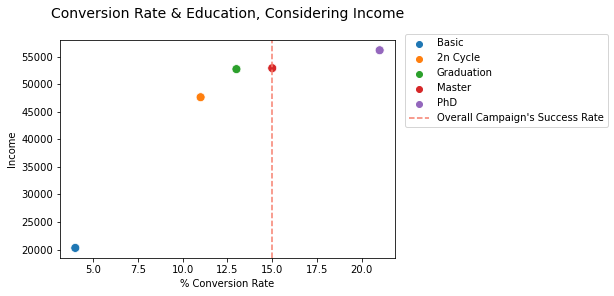

In [13]:
income_education = (ifood.groupby('Education')
                    ['Income'].mean())

education_income = (pd.concat([income_education, 
                               edu_conv_rate], 
                              axis=1)
                    .sort_values(0)
                    .rename(columns={0: '% Conversion Rate'}))

explain_plot(education_income, 
             x='% Conversion Rate', 
             y='Income')
plt.title("Conversion Rate & Education, Considering Income\n", 
          size=14)

plt.legend(loc=(1.03, 0.6));

Anyway, before proceeding to another demographic factor, it is interesting to note that there is no huge average income difference between customers who have graduated (\\$52K) vs those with masters (\\$52K) but there is a slight difference between the conversion rate. What if this small difference in income is what really determines the conversion rate? 

## Marital Status

The next demographic of interest is the marital status of the customers. Evidently, customers who consider themselves as YOLO or Absurd have the highest conversion rate (50% against the campaign's 15%). Additionally, those who consider themselves as Alone, Widow, Single, or Divorced have conversion rates higher than that recorded in the campaign; 33%, 25%, 22%, and 21% respectively. The groups that falls short of the campaign's success rate are those who are married (11%) or together (10%). What could be a good explanation to these success rate values?

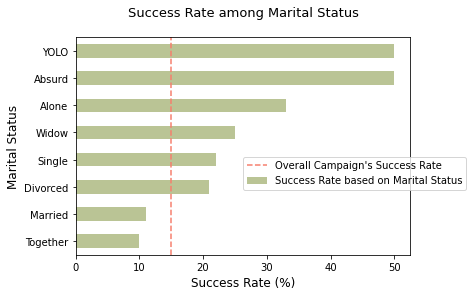

In [14]:
marital_conv_rate = conversion_rate('Marital_Status', ifood)

(marital_conv_rate
 .sort_values()
 .plot(kind='barh', 
       color='#8c9d4f', 
       alpha=0.6, 
       label='Success Rate based on Marital Status'))

plt.axvline(x=15, color='#f67e6d', linestyle='--',
            label="Overall Campaign's Success Rate")

plt.legend(loc=(0.5, 0.3))
plt.ylabel('Marital Status', size=12)
plt.xlabel('Success Rate (%)', size=12)
plt.title('Success Rate among Marital Status\n', size=13);

### The Effect of Numbers

Just like we did when analyzing education level, here we'll also check the frequency of participants in each marital status category. Let's divide the results from this analysis into three parts:

1. The first part looks at the results from the YOLO, Absurd and Alone categories. YOLO and Absurd categories each has two customers with 50% conversion rate. In other words, one customer was converted while the other was not. Somehow, a similar situation is observed in the Alone category. With only three customers in this group, a 33% conversion rate means that only one out of three customers in this category purchased products in this campaign. With the low number of participants in this groups and the high conversion rates, the result are really promising but misleading. I would suggest that these categories be merged with a related category to avoid the promising yet misleading results.

2. The second part looks at the results from the Divorced, Single, and Widow categories. As discussed before, the categories in this second part provided a really promising conversion rate as compared to what was gotten from the campaign. Additionally, the number of customers in each group is reasonable; that is, the widow category has 77 customers, the divorced group has 232 participants, and the Single group has 480 customers. 

3. The final part looks at the results from the Together and Married group. As can be seen, these groups have the over 500 participants and the lowest conversion rate compared to the overall campaign's success rate. 

In general, we can conclude that as the number of participants decreases, the conversion rate goes up with an exception witnessed in the Single's category where the number of customers in the this group is more and the conversion rate is high. However, caution should be taken when interpreting this data because we've seen how misleading it can be.

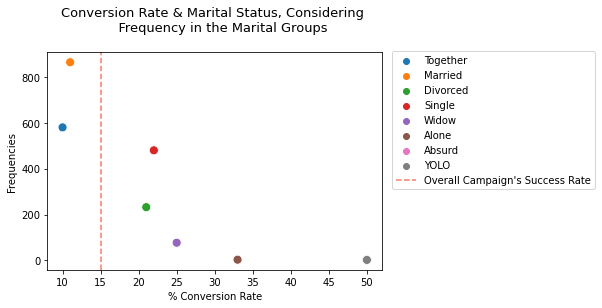

In [15]:
marital_count = ifood['Marital_Status'].value_counts()

marital_conv_frq = (pd.concat([marital_count, marital_conv_rate],
                              axis=1).rename(columns={
                                  'Marital_Status': 'Frequencies',
                                  0: '% Conversion Rate'
                              }).sort_values('% Conversion Rate'))

explain_plot(marital_conv_frq, x='% Conversion Rate', y='Frequencies')
plt.legend(loc=(1.03, 0.37))
plt.title("""Conversion Rate & Marital Status, Considering 
    Frequency in the Marital Groups\n""",
    size=13);

### The Dependants Effect

Another explanation that can be explain the success rate in marital status is the number of dependants. 
Anyway, before we jump in to the nitty-gritty let's create a new feature called `'Dependants'` which is the summation of the features `'Kidhome'` and `'Tenhome'`. Being that the created feature will not be used when building a predictive model, we'll have to use a copy of `ifood` dataset.

In [16]:
copy_ifood = ifood.copy()

copy_ifood['Dependants'] = copy_ifood['Kidhome'] + copy_ifood['Teenhome']
copy_ifood[['Kidhome', 'Teenhome', 'Dependants']].head(3)

,Kidhome,Teenhome,Dependants
0,0,0,0
1,1,1,2
2,0,0,0


Next we compute the average of the number of dependants in each marital group. The results shows that basically all the marital groups have an average of one dependant, except for the Absurd category where there are no dependants and the Alone category which has an average of two dependants. Therefore, the average number of dependants does not really explain much about conversion rate within the marital status feature. Also keep in mind that the low number of customers within the Alone, Absurd, and YOLO groups give misleading results.

In [17]:
dependant_count = (copy_ifood
                   .groupby('Marital_Status')
                   ['Dependants']
                   .sum())

dep_conv = (pd.concat([dependant_count, marital_conv_rate],
                      axis=1)
            .rename(columns={0: '% Conversion Rate',
                             'Dependants': 'Frequencies'})
            .sort_values('% Conversion Rate'))

(dep_conv['Frequencies']/marital_count).round(0)

Absurd      0.0
Alone       2.0
Divorced    1.0
Married     1.0
Single      1.0
Together    1.0
Widow       1.0
YOLO        1.0
dtype: float64

### The Income Effect

The final factor we'll consider when interpreting the conversion rates in marital status is the effect of income. And as can be seen from the results, income does not clearly explains the success rate within the marital status categories because the result are somewhat random.

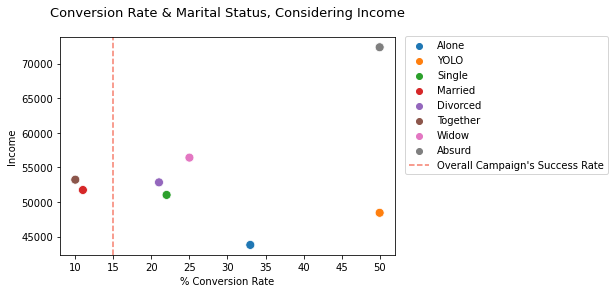

In [18]:
inc_marital = ifood.groupby('Marital_Status')['Income'].mean()
inc_marital_conv = (pd.concat([inc_marital, marital_conv_rate], 
                              axis=1)
                    .rename(columns={0: '% Conversion Rate'})
                    .sort_values('Income'))

explain_plot(inc_marital_conv, x='% Conversion Rate', y='Income')
plt.legend(loc=(1.03, 0.37))
plt.title("Conversion Rate & Marital Status, Considering Income\n", 
          size=13);

## Age Group

Another feature of interest is age. However, before diving deep, let's create four categories of the age feature to allow for ease in analysis and interpretation. These categories are 15 years apart, that is `18-32`, `33-47`, `48-62`, and `63+`. Also, since we'll not be using them in creating a predictive model, we'll create them in the `copy_ifood` dataframe that was created earlier on. A quick check shows that majority of clients in this campaign were aged 33-47 (*N*=984) and aged 48-62 (*N*=728) while the minority were those aged 63+ (*N*=182). 

In [19]:
bins= [18,33,48,63, np.inf]
labels = ['18-32','33-47','48-62','63+']

copy_ifood['Age_group'] = pd.cut(copy_ifood['Age'], 
                                 bins=bins, 
                                 labels=labels, 
                                 right=False)

copy_ifood['Age_group'].value_counts()

33-47    984
48-62    728
18-32    346
63+      182
Name: Age_group, dtype: int64

In terms of age, customers within the age groups 18-32 and 63+ have conversion rates above the campaign's success rate;  21% and 16% respectively. Customers within the age brackets 33-47 and 48-62 have conversion rates below the one recorded in the campaign; 14% and 13% respectively. 

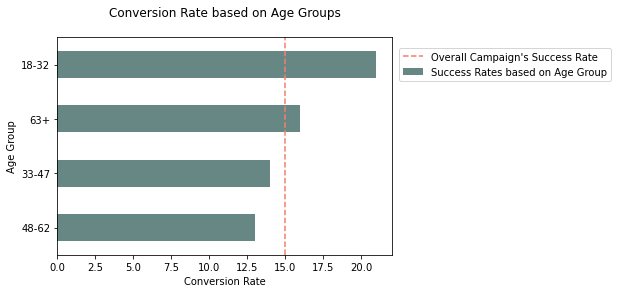

In [20]:
age_conv_rate = (conversion_rate('Age_group', copy_ifood)
                 .sort_values())

age_conv_rate.plot(kind='barh', color='#678785', 
                   label='Success Rates based on Age Group', 
                   title='Conversion Rate based on Age Groups\n')
plt.ylabel('Age Group')
plt.xlabel('Conversion Rate')
plt.axvline(x=15, color='#f67e6d', linestyle='--',
            label="Overall Campaign's Success Rate")
plt.legend(loc=(1.02, 0.8));

### The Income Effect 

To explain the conversion rate seen in these age groups we'll look at the income feature. A careful look at it is noticeable that as age increases the income also increases. However, the same cannot be said for conversion rate. We see that customers in age group 18-32 have the lowest average income yet they have the highest conversion rate of 21%. Interestingly, those in the age category 63+ have the highest income among the age groups and they have a conversion rate that is just a percent higher than the campaign's success rate. This result may mean that the company should focus products that target customers in 18-32 age group.

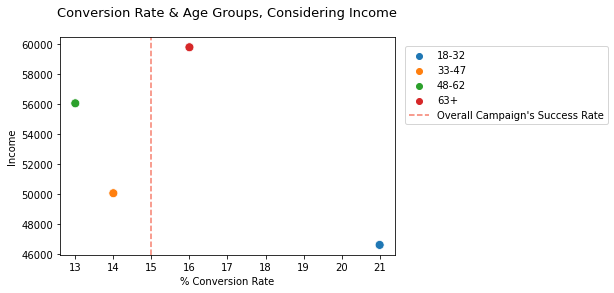

In [21]:
inc_age = copy_ifood.groupby('Age_group')['Income'].mean()

inc_age_conv = (pd.concat([inc_age, age_conv_rate], 
                              axis=1)
                    .rename(columns={0: '% Conversion Rate'})
                    .sort_values('% Conversion Rate'))

explain_plot(inc_age_conv, x='% Conversion Rate', y='Income')
plt.legend(loc=(1.03, 0.6))
plt.title("Conversion Rate & Age Groups, Considering Income\n", 
          size=13);

# **BEHAVIORAL CUSTOMER SEGMENTATION**

The term "behavioral segmentation" refers to a marketing technique where clients are divided into groups based on how they engage with a particular company or website. These segments could involve classifying clients according to their attitudes toward a product, brand, or service; their use of the product(s) or service(s); their general familiarity with the brand and its items; and, ultimately, their purchasing behaviors, such as only making purchases on special occasions like holidays or birthdays, etc. Let's dive into behavioral customer segmentation.

## Complains

The first behavior that we'll look at is from the `Complain` feature. From the analysis it is established that there were 21 customers who complained and and as a result 17 ended up rejecting products in the last campaign. Although twenty-one complaints may appear small, it seems that customer complaints should be addressed and if best, avoided.

In [22]:
complaints = (ifood[ifood['Complain'] == 1]
              [['Complain', 'Response']])

print('Number of Complaints: ', complaints['Complain'].sum())

print('Rejection Rate after Complaints: ', 
      str(round(100-(complaints['Response'].sum()/len(complaints))*100))+'%')

Number of Complaints:  21
Rejection Rate after Complaints:  86%


## Recency, Frequency, Monetary Value (RFM) 

The RFM segmentation techniques that involves the calculation of three customer behavior metrics. Recency measures how recent was each customer's last purchase. Frequency measures how many purchases the customer has done during a particular period of time. Monetary reflects how much a customer has spent with the brand during a particular period of time. Once we have calculated these numbers, we'll group them into some sort of categorization using the k-means clustering.

### Feature Engineering

To get started, we'll have to do some feature engineering using the `copy_ifood` dataframe. Here, we'll create the frequency and monetary value features only because the recency feature is already available. From the data provided all the features that deals with the amount of money spent has the string `'Mnt'` while those features that provides about frequency contain the string `'Purchases'`. Therefore, we'll use this knowledge to extract the necessary features.

In [31]:
monetary_cols = list(copy_ifood.filter(regex='Mnt').columns)
frequency_cols = list(copy_ifood.filter(regex='Purchases').columns)

print('Monetary Features: ', monetary_cols)
print()
print('Frequency Features: ', frequency_cols)

Monetary Features:  ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
Frequency Features:  ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']


From here we then create the RFM features by conducting summation within all the monetary features and frequency features. The monetary feature sums up the amount spent to purchase different products from the app. The frequency feature is the sum of all purchases made through discount, or catalog, or directly in the store, or through the website.

In [34]:
copy_ifood['MonetaryValue'] = (copy_ifood[monetary_cols]
                               .apply(np.sum,axis=1))

copy_ifood['Frequency'] = (copy_ifood[frequency_cols]
                                 .apply(np.sum, axis=1))

rfm_cols = ['Recency', 'Frequency', 'MonetaryValue']

rfm_data = copy_ifood[['ID']+rfm_cols].set_index('ID')
rfm_data.head()

,Recency,Frequency,MonetaryValue
ID,,,
5524,58,25,1617
2174,38,6,27
4141,26,21,776
6182,26,8,53
5324,94,19,422


### Data Preprocessing

First let's review the underlying assumptions before exploring how we do consumer segmentation using K-means. First, a ll variables must all have symmetrical distributions. This implies that the distribution is not skewed. The second assumption is that the average values of all variables are the same. This is essential to ensuring that the k-means algorithm gives each metric the same weight. Finally, t he variance of each variable must then be scaled to the same levels. Similar to averages, it facilitates convergence of the algorithm and guarantees that each variable is given equal weight.

# **CLUSTERING FOR SEGMENTATION**

To avoid overlooking of customers' behavioral patterns, clustering will be used instead of personal intuitions during segmentation. For this case study, the criteria for segmentation is that regardless of marital status, and education level, the customers are separated based on their income level,  age, and purchase totals. Using these criteria, the results can be differential marketing strategy for customers that have, say, high income and low purchasing versus those with low income and high purchasing.

In [ ]:
cols = ['Income', 'Age', 'Purchase_total', 'Response']
marketing_clust = marketing[cols]

## Training and Validation Data

First the data is separated into training and testing portions to test for the accuracy of the clustering method used.

In [ ]:
from sklearn.model_selection import train_test_split

X_data = marketing_clust.drop('Response', axis=1)
y_data = marketing_clust['Response']

X_train, X_test, y_train, y_test =\
    train_test_split(X_data, y_data, 
                     test_size=0.3, 
                     random_state=123)

X_train.shape, X_test.shape

## Standardization 

Next we standardize the training data and upon verification the mean value of practically all the columns is 0 and the standard deviation is 1. This ensures that all the columns get equal weight when calculation the similarity or distance between customers.

In [ ]:
from sklearn.preprocessing import StandardScaler
from warnings import filterwarnings
filterwarnings('ignore')

scaler = StandardScaler()

clust_cols = ['Income', 'Age', 'Purchase_total']
scaled_cols = ['Income_scaled', 'Age_scaled', 'Purchase_scaled']
X_train[scaled_cols] = scaler.fit_transform(X_train[clust_cols])

## Kmeans Clustering and Dimensionality Reduction

To choose an appropriate number clusters, the silhouttes score is used to measure how well a clustering fit the data. In this case, the higher score (optimal number of clusters) is from two clusters.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(2, 10):
    km_model = KMeans(n_clusters=k, random_state=123)
    cluster_assignments = km_model.fit_predict(X_train[scaled_cols])
    sil_scores.append(silhouette_score(X_train[scaled_cols], 
                                       cluster_assignments))

plt.plot(range(2, 10), sil_scores, color='#306958')
plt.ylabel('Avg. Silhouette score')
plt.xlabel('Number of Clusters: K');

## Evaluating KMeans Performance

A kmean model is created setting the number of clusters to 2 and fit to the training data in order to predict the clusters. The average silhouette score for this number of clusters is 0.51.

In [ ]:
km_model = KMeans(n_clusters=2, random_state=123)
X_train['Income_Clusters'] = (km_model
                              .fit_predict(X_train[scaled_cols]))

silhouette_score(X_train[clust_cols], X_train['Income_Clusters'])

For the test data, the average silhouette score (0.53) is an improvement from that computed for the training data (0.51).

In [ ]:
X_test[scaled_cols] = scaler.fit_transform(X_test[clust_cols])
X_test['Income_Clusters'] = (km_model
                             .predict(X_test[scaled_cols]))

silhouette_score(X_test[clust_cols], X_test['Income_Clusters'])

To understand the cause for this increase, a visualization will be created on the training and test data. But first, the data is reduced to two dimensions using PCA while preserving the distance between the points.

In [ ]:
from sklearn.decomposition import PCA

def pca_output(data):
    return PCA(n_components=2).fit_transform(data[scaled_cols])

pca_train = pca_output(X_train)
pca_test = pca_output(X_test)

X_train['pc1'], X_train['pc2'] = pca_train[:,0], pca_train[:,1]
X_test['pc1'], X_test['pc2'] = pca_test[:,0], pca_test[:,1]

Before going ahead, a function is defined to plot clusters.

In [ ]:
markers = ['.', 'x']
colors = ['#ed7d00', '#61b4f6']
alpha = [0.6, 0.6]

def plot_clusters(data):
    for clust in range(data['Income_Clusters'].nunique()):
        
        temp = data[data['Income_Clusters']==clust]
        
        plt.scatter(temp['pc1'], temp['pc2'], 
                    marker=markers[clust], 
                    label='cluster '+str(clust), 
                    color=colors[clust], 
                    alpha=alpha[clust])

    plt.legend(loc='upper left')
    plt.xlabel('PC1')
    plt.ylabel('PC2');

The x and y axes are Principal Components and therefore not easily interpretable being that they are derived from combinations of the original features. However, by visualizing the clusters, it is evident how good the clusters are based on how much they overlap. However, there is a data point that is far from its cluster.

In [ ]:
import seaborn as sns

plot_clusters(X_train)

The outlier is also evident in the average household income.

In [ ]:
sns.boxplot(X_train['Income'])
plt.title('Distribution of Income\n', size=13);

In the test data, the improvement of the average silhouette can be attributed to the tight clusters.

In [ ]:
plot_clusters(X_test)

To understand the clusters, the average values of the original features used for clustering can be computed against the two clusters visually. From the results it is clear that the income and purchase totals varies significantly between the clusters and perhaps for age.

In [ ]:
X_test.groupby('Income_Clusters')[clust_cols].mean()

## Interpreting Clusters

As an interpretation, cluster 0 can be said to be comprised of high income customers with high purchasing habits while cluster 1 consist of customers who have low income earner and thus lower spenders. The age difference is not that large but it is evident that those in cluster 0 are somewhat older than those in cluster 1. Note that for this visualization, the standardized values are used instead of the original feature values due to scaling.

In [ ]:
(X_test
 .groupby('Income_Clusters')[scaled_cols]
 .mean()
 .plot
 .bar(color=['#442e51', '#396d58', '#447ca4'], 
      alpha=0.8))

plt.axhline(0, 
            color='#aba396', 
            linestyle='--', 
            alpha=0.5)
plt.ylabel('Scaled Values')
plt.xlabel('Cluster')
plt.title('Customer Segmentation based on Income, Age, Purchase\n', 
          size=13);

With this information, it is evident that customers classified as low income earners and spenders have low conversion rate (10 percent against the overall 15 percent) while those categorized as high income earners and spenders have a high conversion rate (23 percent against the overall 15 percent).

In [ ]:
income_cluster = pd.concat([X_test['Income_Clusters'], 
                            y_test], 
                           axis=1)

(conversion_rate('Income_Clusters', income_cluster)
 .plot.barh())

plt.yticks(ticks=[0, 1], 
           labels=['Low-income & low spenders', 
                   'High-income & high spenders'])
plt.xlabel('Conversion Rate')
plt.ylabel('Cluster')
plt.title('Conversion Rate based on Income, Purchase & Age\n', 
          size=13);

# **CREATING A PREDICTIVE MODEL**

The aim of this section is to create a predictive model which will allow the company to maximize the profit of the next marketing campaign.

## Selecting Necessary Variables

First, the selection of variables to proceed with is important.

1. All the variables that were created for the purpose of customer segmentation analysis will be dropped.
 
2. Variables like `Z_CostContact` and `Z_revenue` have constant values across each entry thus they are also removed. 

In [ ]:
col_remove = ['ID', 'Z_CostContact', 'Z_Revenue', 'Age_group', 
              'Number_Purchases', 'Purchase_total', 'Dependants']
marketing = marketing.drop(col_remove, axis=1)

## One Hot Encoding 

The categorical columns are also converted to numerical data types to allow for the use of the algorithms that will be used when creating a predictive model.

In [ ]:
categ_cols = ['Education', 'Marital_Status']
marketing = pd.get_dummies(marketing)

Next, the data is split into training and validation sets

In [ ]:
X_data = marketing.drop('Response', axis=1)
y_data = marketing['Response']

X_train, X_val, y_train, y_val =\
    train_test_split(X_data, y_data, random_state=123, test_size=0.30)

Before proceeding, a function is created that contains a pipeline to scale the data and fit a classifier. The function then outputs the accuracy scores.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, 
                             confusion_matrix,
                             classification_report)
    
def pipe_fit_score(classifier):
    venue_pipe = Pipeline([('scaler', StandardScaler()), 
                           ('clf', classifier)])
    
    y_pred = venue_pipe.fit(X_train, y_train).predict(X_val)
    
    print(pd.DataFrame(confusion_matrix(y_val, y_pred), 
                        columns=['Positive', 'Negative'], 
                        index=['Positive', 'Negative']))
    print()
    print(classification_report(y_val, y_pred))
    print()
    return roc_auc_score(y_val, y_pred)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
pipe_fit_score(LogisticRegression())

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=123)
pipe_fit_score(rfc)

### K-Neighbor Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
pipe_fit_score(KNeighborsClassifier())

### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
pipe_fit_score(SVC())

## Classification

When default parameters are used, logistic regression gives the best predictive scores in terms of accuracy (90 percent) and also the area under curve (0.72). More on classification will be tackled later on.

## Hyperparameter Tuning

In this section, the model parameters are tuned to determine the best model parameters that can be used for prediction

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_rfc = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['auto'],
    'max_depth' : [None,3,5,8],
    'criterion' :['gini'],
    'min_samples_split':[2,3,4]}

rfc_cv = GridSearchCV(RandomForestClassifier(random_state=5),
                            param_grid=param_rfc,
                            cv=5, verbose=1)

rfc_cv.fit(X_train, y_train)
rfc_tune_acc = pipe_fit_score(rfc_cv.best_estimator_)
print('Accuracy: ', rfc_tune_acc)